<a href="https://colab.research.google.com/github/Edenshmuel/ICU_Nutrition_ML/blob/main/Neural_Network_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the Data**

Importing Necessary Libraries

In [1]:
import copy
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

Cloning the Project Repository

In [2]:
!git clone https://github.com/Edenshmuel/ICU_Nutrition_ML.git

fatal: destination path 'ICU_Nutrition_ML' already exists and is not an empty directory.


Loading the Dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Edenshmuel/ICU_Nutrition_ML/refs/heads/main/Food_and_Nutrition__.csv")
df.head()

,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,Protein,Sugar,Sodium,Calories,Carbohydrates,Fiber,Fat,Breakfast Suggestion,Lunch Suggestion,Dinner Suggestion,Snack Suggestion,Disease
0,25,Male,180,80,Moderately Active,Omnivore,2000,120,125.0,24.0,2020,250,30.0,60,Oatmeal with berries and nuts,Grilled chicken salad with mixed greens,Salmon with roasted vegetables,Greek yogurt with fruit,Weight Gain
1,32,Female,165,65,Lightly Active,Vegetarian,1600,80,100.0,16.0,1480,200,24.0,40,Tofu scramble with veggies,Lentil soup with whole wheat bread,Vegetable stir-fry with brown rice,Apple with almond butter,"Weight Gain, Hypertension, Heart Disease"
2,48,Male,175,95,Sedentary,Vegan,2200,100,150.0,20.0,2185,300,36.0,65,Tofu and veggie breakfast burrito,Black bean burger on a whole wheat bun,Lentil and vegetable curry,Trail mix,Weight Gain
3,55,Female,160,70,Very Active,Omnivore,2500,140,175.0,28.0,2680,350,42.0,80,Greek yogurt with granola and fruit,Chicken and vegetable stir-fry,Turkey chili with brown rice,Banana with peanut butter,Weight Gain
4,62,Male,170,85,Sedentary,Vegetarian,2000,80,125.0,16.0,1815,250,30.0,55,Scrambled eggs with whole wheat toast and avocado,Quinoa salad with chickpeas and vegetables,Vegetarian chili with cornbread,Fruit and nut mix,Weight Gain


**Data Preprocessing**

Categorize Features: Numerical, Categorical, and Skewed Columns

In [4]:
numerical_features = ["Ages", "Height", "Weight", "Fiber", "Sodium"]
categorical_features = ["Gender", "Dietary Preference"]

Features identified as right-skewed from EDA. Applying log transformation

In [5]:
right_skewed_features = ["Fat"]

**Data Preprocessing: Pipelines for Scaling, Encoding, and Log Transformation**

Log Transform + Scaling for skewed features

In [53]:
log_scaler_pipeline = Pipeline(steps=[("log_transform", FunctionTransformer(np.log1p, validate=True)),
    ("scaler", MinMaxScaler())])

Standard Scaling for non-skewed features

In [54]:
scaler_pipeline = Pipeline(steps=[("scaler", MinMaxScaler())])

One-Hot Encoding for categorical features

In [55]:
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

This function converts the "Disease" column, which contains multiple diseases as a comma-separated string, into a multi-hot encoded format—creating a separate binary column for each unique disease

In [56]:
def multi_hot_encode_disease(df):
    df = df.copy()
    df["Disease"] = df["Disease"].astype(str).str.split(", ")
    all_diseases = set([d for sublist in df["Disease"] for d in sublist])

    for disease in all_diseases:
        df[disease] = df["Disease"].apply(lambda x: 1 if disease in x else 0)

    df = df.drop(columns=["Disease"])
    return df

disease_transformer = FunctionTransformer(multi_hot_encode_disease)

This code transforms the categorical "Activity Level" column into numerical values, making it suitable for machine learning models

In [10]:
df["Activity Level"].unique()

array(['Moderately Active', 'Lightly Active', 'Sedentary', 'Very Active',
       'Extremely Active'], dtype=object)

In [11]:
activity_mapping = {
    "Sedentary": 0,
    "Lightly Active": 1,
    "Moderately Active": 2,
    "Very Active": 3,
    "Extremely Active": 4
    }

In [12]:
def encode_activity_level(X):
    X = X.copy()
    X["Activity Level"] = X["Activity Level"].map(activity_mapping)
    return X

activity_transformer = FunctionTransformer(encode_activity_level)

This class is a custom scikit-learn transformer that calculates the Body Mass Index (BMI) based on weight and height

In [13]:
class BMICalculator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["BMI"] = X["Weight"] / (X["Height"] ** 2)
        return X

Defines the preprocessing pipeline

In [57]:
num_pipeline = Pipeline(steps=[
    ("bmi_calculator", BMICalculator()),
    ("log_scaled", log_scaler_pipeline),
    ("scaler", scaler_pipeline)])

In [58]:
preprocessor = ColumnTransformer(transformers=[
    ("log_scaled", log_scaler_pipeline, right_skewed_features),
    ("scaled", scaler_pipeline, numerical_features),
    ("activity", activity_transformer, ["Activity Level"]),
    ("cat", cat_transformer, categorical_features),
    ("disease", disease_transformer, ["Disease"])])

To ensure consistency, we remove diseases that appear only once, as they cause mismatched features between training and test sets and provide no learning value for the model

In [39]:
from collections import Counter

df["Disease_Split"] = df["Disease"].astype(str).str.split(", ")

all_diseases = [disease for sublist in df["Disease_Split"] for disease in sublist]
disease_counts = Counter(all_diseases)

print("Single disease count:")
for disease, count in disease_counts.items():
    print(f"{disease}: {count}")

rare_diseases = [disease for disease, count in disease_counts.items() if count < 2]

print("\nRare diseases (appear less than 2 times):")
print(rare_diseases)

Single disease count:
Weight Gain: 1664
Hypertension: 291
Heart Disease: 288
Kidney Disease: 188
Diabetes: 65
Acne: 65

Rare diseases (appear less than 2 times):
[]


In [40]:
df = df[~df["Disease"].str.contains("Weight Loss", na=False)]

In [41]:
X = df.drop(columns=["Daily Calorie Target", "Protein", "Carbohydrates"])
y = df[["Daily Calorie Target", "Protein", "Carbohydrates"]]

Prevent Data Leakage: Remove Columns That Contain Target Information

In [42]:
X = df.drop(columns=["Calories"])

Removing Non-Contributing Columns

In [43]:
columns_to_remove = ["Sugar", "Breakfast Suggestion", "Lunch Suggestion",
                     "Dinner Suggestion", "Snack Suggestion"]

X = df.drop(columns=columns_to_remove)

Analysis showed that keeping 'Sodium' and 'Fiber' significantly reduced the model's error, so I decided to keep them

**Splitting the Data**

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Y Train: {y_train.shape}, Y Test: {y_test.shape}")

Train: (1357, 15), Test: (340, 15)
Y Train: (1357, 3), Y Test: (340, 3)


**Apply the Pipeline**

In [59]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [60]:
print(f"✅ Training Data Processed: {X_train_transformed.shape} (Rows, Features)")
print(f"✅ Test Data Processed: {X_test_transformed.shape} (Rows, Features)")

✅ Training Data Processed: (1357, 19) (Rows, Features)
✅ Test Data Processed: (340, 19) (Rows, Features)


**Baseline Model**

A baseline model is created by randomly shuffling the target values to compare the neural network's performance against a naive prediction

In [24]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [61]:
y_test_copy = np.array(copy.deepcopy(y_test))

np.random.shuffle(y_test_copy)

random_baseline_mae = mean_absolute_error(y_test, y_test_copy, multioutput="raw_values")
random_baseline_mse = mean_squared_error(y_test, y_test_copy, multioutput="raw_values")
random_baseline_rmse = np.sqrt(random_baseline_mse)
random_baseline_r2 = r2_score(y_test, y_test_copy, multioutput="raw_values")

print(f"Random Baseline MAE per target: {random_baseline_mae}")
print(f"Average Random Baseline MAE: {random_baseline_mae.mean():.2f}")

print(f"Random Baseline MSE per target: {random_baseline_mse}")
print(f"Average Random Baseline MSE: {random_baseline_mse.mean():.2f}")

print(f"Random Baseline RMSE per target: {random_baseline_rmse}")
print(f"Average Random Baseline RMSE: {random_baseline_rmse.mean():.2f}")

print(f"Random Baseline R² per target: {random_baseline_r2}")
print(f"Average Random Baseline R²: {random_baseline_r2.mean():.2f}")

Random Baseline MAE per target: [685.00588235  61.05882353  82.21176471]
Average Random Baseline MAE: 276.09
Random Baseline MSE per target: [708023.35882353   6169.07647059  10006.87647059]
Average Random Baseline MSE: 241399.77
Random Baseline RMSE per target: [841.44123908  78.54346867 100.03437644]
Average Random Baseline RMSE: 340.01
Random Baseline R² per target: [-1.16678332 -1.0705406  -1.01134051]
Average Random Baseline R²: -1.08


**Neural Network Model**

This section defines and trains a neural network using K-Fold cross-validation. The model includes batch normalization, dropout, L2 regularization, and an exponentially decaying learning rate. The Mean Absolute Error (MAE) is calculated for each fold and averaged across all folds



In [26]:
#!pip install scikit-learn==1.3.1

In [32]:
#!pip install --upgrade scikit-learn scikeras --quiet

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [28]:
y_train_np = y_train.to_numpy()

In [29]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.96, staircase=True)

In [30]:
def build_model():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_transformed.shape[1],)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(y_train.shape[1], activation='linear')])

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [75]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

mae_per_column = []

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for train_idx, val_idx in kfold.split(X_train_transformed):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    model = build_model()

    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=16, verbose=1,
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    y_val_pred = model.predict(X_val_fold)

    fold_mae_per_column = mean_absolute_error(y_val_fold, y_val_pred, multioutput="raw_values")

    mae_per_column.append(fold_mae_per_column)

    print(f"MAE per column in the current fold: {fold_mae_per_column}")

mae_per_column = np.array(mae_per_column)

mean_mae_per_column = mae_per_column.mean(axis=0)

print("\nAverage MAE per column:")
for i, col_name in enumerate(["Calories", "Carbohydrates", "Protein"]):
    print(f"{col_name}: {mean_mae_per_column[i]:.2f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1861849.8750 - mae: 890.0728 - val_loss: 1803105.1250 - val_mae: 865.8041
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1777341.2500 - mae: 858.9823 - val_loss: 1601180.2500 - val_mae: 789.8278
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1610514.1250 - mae: 788.4491 - val_loss: 1455904.0000 - val_mae: 778.6009
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1365258.3750 - mae: 717.7386 - val_loss: 1092694.8750 - val_mae: 668.5253
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1076285.6250 - mae: 634.8832 - val_loss: 811630.3125 - val_mae: 560.0317
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 834084.6250 - mae: 549.8736 - val_loss: 540628.5000 - val_mae: 445.0628
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 597705.2500 - mae: 460.4673 - val_loss: 386085.5625 - val_mae: 370.5582
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 371022.0312 - mae: 356.6664 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1837780.0000 - mae: 884.2163 - val_loss: 1762462.0000 - val_mae: 857.3643
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1794285.8750 - mae: 859.8529 - val_loss: 1579512.0000 - val_mae: 786.0781
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1624749.0000 - mae: 789.4657 - val_loss: 1439340.5000 - val_mae: 767.9774
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1355157.8750 - mae: 712.5107 - val_loss: 1067783.1250 - val_mae: 648.2739
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1116358.2500 - mae: 644.3158 - val_loss: 759531.3125 - val_mae: 532.6957
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 843903.4375 - mae: 555.7745 - val_loss: 652385.3750 - val_mae: 493.1085
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 566175.5625 - mae: 449.8307 - val_loss: 419099.7188 - val_mae: 389.0021
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 388596.5625 - mae: 366.5996 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1791155.6250 - mae: 874.1826 - val_loss: 1833967.6250 - val_mae: 879.1959
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1748925.3750 - mae: 852.8652 - val_loss: 1717874.6250 - val_mae: 844.9274
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1613298.0000 - mae: 790.2286 - val_loss: 1536730.0000 - val_mae: 793.1366
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1391171.2500 - mae: 722.8714 - val_loss: 1088183.0000 - val_mae: 671.9639
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1071008.8750 - mae: 633.3823 - val_loss: 963990.2500 - val_mae: 614.8377
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 844633.5625 - mae: 554.6964 - val_loss: 713303.1250 - val_mae: 519.6965
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 557175.2500 - mae: 447.3891 - val_loss: 431703.5938 - val_mae: 391.2056
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 366638.4375 - mae: 351.7507 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1865626.7500 - mae: 889.3148 - val_loss: 1766063.3750 - val_mae: 864.6967
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1761755.0000 - mae: 851.1014 - val_loss: 1604284.0000 - val_mae: 796.3763
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1604751.6250 - mae: 784.3214 - val_loss: 1548753.0000 - val_mae: 812.7124
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1365980.5000 - mae: 717.5435 - val_loss: 1223708.7500 - val_mae: 698.8174
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1120044.8750 - mae: 645.1430 - val_loss: 918136.7500 - val_mae: 594.1374
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 805470.2500 - mae: 541.7015 - val_loss: 702199.6250 - val_mae: 514.6925
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 583551.8125 - mae: 454.8192 - val_loss: 383507.4375 - val_mae: 367.8358
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 376395.7812 - mae: 362.2997 - val

**Plot Training vs. Validation Loss**

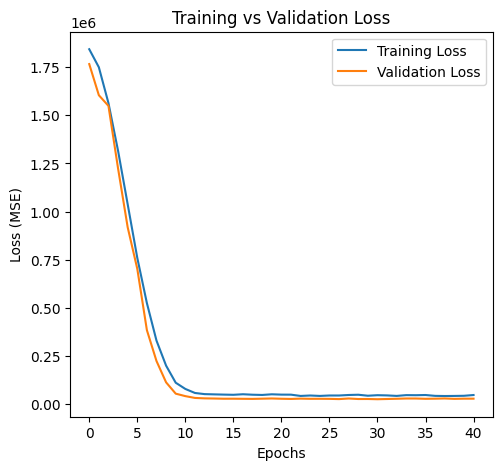

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()

**Model Evaluation**

In [77]:
y_test_pred = model.predict(X_test_transformed)

test_mae = mean_absolute_error(y_test, y_test_pred, multioutput="raw_values")
test_mse = mean_squared_error(y_test, y_test_pred, multioutput="raw_values")
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred, multioutput="raw_values")

print("\n**Model Performance Comparison vs. Baseline**")

print("\nMAE - Mean Absolute Error:")
print(f"Random Baseline: {np.round([631.62, 58.01, 82.83], 2)}")
print(f"Model Performance: {np.round(test_mae, 2)}")

print("\nMSE-Mean Squared Error:")
print(f"Random Baseline: {np.round([637653.03, 5360.05, 10613.26], 2)}")
print(f"Model Performance: {np.round(test_mse, 2)}")

print("\nRMSE - Root Mean Squared Error:")
print(f"Random Baseline: {np.round([798.53, 73.21, 103.02], 2)}")
print(f"Model Performance: {np.round(test_rmse, 2)}")

print("\nR² - Proportion of Variance Explained by the Model:")
print(f"Random Baseline: {np.round([-0.94, -0.94, -1.03], 2)}")
print(f"Model Performance: {np.round(test_r2, 2)}")

print("\nAverage Metric Comparison Between Model and Baseline:")
print(f"Average Random Baseline MAE: {np.round(257.49, 2)}, Model MAE: {np.round(test_mae.mean(), 2)}")
print(f"Average Random Baseline MSE: {np.round(217875.45, 2)}, Model MSE: {np.round(test_mse.mean(), 2)}")
print(f"Average Random Baseline RMSE: {np.round(324.92, 2)}, Model RMSE: {np.round(test_rmse.mean(), 2)}")
print(f"Average Random Baseline R²: {np.round(-0.97, 2)}, Model R²: {np.round(test_r2.mean(), 2)}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

**Model Performance Comparison vs. Baseline**

MAE - Mean Absolute Error:
Random Baseline: [631.62  58.01  82.83]
Model Performance: [196.31  26.42  25.28]

MSE-Mean Squared Error:
Random Baseline: [637653.03   5360.05  10613.26]
Model Performance: [88948.05   980.21  1295.05]

RMSE - Root Mean Squared Error:
Random Baseline: [798.53  73.21 103.02]
Model Performance: [298.24  31.31  35.99]

R² - Proportion of Variance Explained by the Model:
Random Baseline: [-0.94 -0.94 -1.03]
Model Performance: [0.73 0.67 0.74]

Average Metric Comparison Between Model and Baseline:
Average Random Baseline MAE: 257.49, Model MAE: 82.66999816894531
Average Random Baseline MSE: 217875.45, Model MSE: 30407.76953125
Average Random Baseline RMSE: 324.92, Model RMSE: 121.8499984741211
Average Random Baseline R²: -0.97, Model R²: 0.7099999785423279


**Tracking Model Performance Across Runs**

In [81]:
import os

# Define the file to store results
results_file = "model_results.csv"

current_results = {
    "MAE": np.round(test_mae.mean(), 2),
    "MSE": np.round(test_mse.mean(), 2),
    "RMSE": np.round(test_rmse.mean(), 2),
    "R2": np.round(test_r2.mean(), 2)}

if os.path.exists(results_file):
    previous_results = pd.read_csv(results_file)

    std_results = previous_results.std().round(2)
    mean_results = previous_results.mean().round(2)

    print("\nComparison with Previous Run:")
    last_run = previous_results.iloc[-1]
    for metric in current_results:
        prev_value = last_run[metric]
        current_value = current_results[metric]
        change = current_value - prev_value
        print(f"{metric}: {current_value} (Previous: {prev_value}, Change: {change:+.2f})")

    print("\nHistorical Performance Stats:")
    for metric in current_results:
        print(f"{metric}: Mean = {mean_results[metric]}, Std = {std_results[metric]}")

else:
    print("\nNo previous results found. This is the first recorded run.")

# Append new results to the file
new_entry = pd.DataFrame([current_results])
new_entry.to_csv(results_file, mode='a', header=not os.path.exists(results_file), index=False)

print("\n✅ Results saved successfully!")


Comparison with Previous Run:
MAE: 82.66999816894531 (Previous: 82.67, Change: -0.00)
MSE: 30407.76953125 (Previous: 30407.77, Change: -0.00)
RMSE: 121.8499984741211 (Previous: 121.85, Change: -0.00)
R2: 0.7099999785423279 (Previous: 0.71, Change: -0.00)

Historical Performance Stats:
MAE: Mean = 85.78, Std = 3.44
MSE: Mean = 30500.68, Std = 116.28
RMSE: Mean = 123.35, Std = 1.69
R2: Mean = 0.68, Std = 0.03

✅ Results saved successfully!
